# ArUco 마커 위치 추정
이번 장에서는 ArUco 마커를 인식하고, 카메라와 마커 간 거리와 마커의 각도를 추정해본다. 이를 위해서는 `0. 카메라 왜곡 보정`에서 얻었던 `cameraMatrix`와 `distCoeffs`가 필요하다.

먼저 필요한 모듈과 변수를 설정한다.

In [3]:
import cv2
from zumi.zumi import Zumi
from zumi.util.camera import Camera

# DEBUG Module
import time
from IPython.display import clear_output

camera = Camera(image_w=480, image_h=320, framerate=30)
camera.start_camera()
zumi = Zumi()

dst = -1
is_turn = -1
is_stop = 0
angle = 0
is_moving = True

Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected


`@static_vars`를 사용하여 함수에서만 유효한 변수를 따로 설정할 수 있다. 마커의 크기는 상대적인 비교만 하기 위하여 대각선에 위치하는 점들의 차이만을 가지고 유추하였다. 이를 이용하여 카메라에서 가장 가까운 마커를 찾아낼 수 있다. 해당 마커의 `arctan(dx/dz)`를 통하여 카메라 원점과의 각도를 얻어낼 수 있다. 이 값을 theta라고 할 때, 주미 몸체의 크기를 이용하여 마커에 부딪치지 않기 위해 우리가 회전해야 할 각도를 계산할 수 있다.

In [ ]:
import numpy as np
import cv2.aruco as aruco

# Initialize Static Vars
def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

# ArUco Parameter
@static_vars(
    dict=aruco.Dictionary_get(aruco.DICT_4X4_50),
    params=aruco.DetectorParameters_create()
)
def detectMarkers(image):
    corners, ids, _ = aruco.detectMarkers(
        image, detectMarkers.dict, parameters=detectMarkers.params
    )
    return corners, ids

# Get Approximate Marker Size
def getMarkerSize(corner):
    return sum(
        np.abs(corner[0] - corner[2]) +
        np.abs(corner[1] - corner[3])
    )

# Get Only the Nearest Marker
def getNearestMarker(image):
    corners, ids = detectMarkers(image)
    if type(ids) == type(None):
        return [None], [None]

    return sorted(
        zip(corners, ids),
        key=lambda res: getMarkerSize(res[0][0]),
        reverse=True
    )[0]

@static_vars(
    size=0.01,
    required_length=0.045,
    mtx=np.array([
        [562.09580346, 0, 253.3062917],
        [0, 561.61322047, 100.93353004],
        [0, 0, 1]
    ]),
    dist=np.array([[
        0.09713601,
        0.3213626,
       -0.0052866,
        0.00656109,
       -2.14653388
    ]])
)
def getAngle(corner, angle):
    _, tvec, _ = aruco.estimatePoseSingleMarkers(
        corner,
        getAngle.size,
        getAngle.mtx,
        getAngle.dist
    )
    theta = np.arctan(tvec[0][0][0] / tvec[0][0][2])
    sign = -1 if theta < 0 else 1
    required_theta = sign * getAngle.required_length / tvec[0][0][2]
    angle += np.rad2deg(required_theta - theta)
    return angle

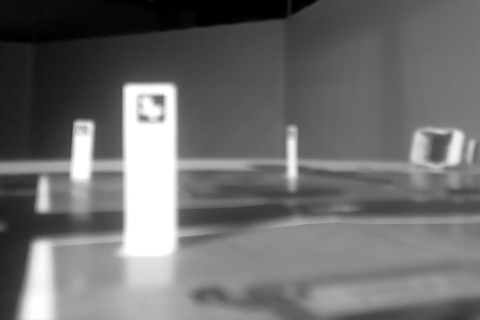

stop OpenCV(3.4.2) /home/pi/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:65: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) ) && npoints == std::max(ipoints.checkVector(2, 5), ipoints.checkVector(2, 6)) in function 'solvePnP'



In [10]:
try:
    frame = camera.capture()
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    camera.show_image(gray)

    corner, idx = getNearestMarker(gray)
    angle = getAngle(corner, zumi.read_z_angle())
    print(corner, idx, angle)
    is_moving = True

except Exception as err:
    is_moving = False
    zumi.stop()
    print("stop", err)

In [11]:
# Release Camera
camera.close()

Closing PiCamera
